In [1]:
pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch torchvision

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder
import torch
from transformers import AutoProcessor, CLIPModel


In [4]:
airbnb = pd.read_csv("airbnb-listings.csv", delimiter=";")


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,2,27,66) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
airbnb.shape

(494954, 89)

In [6]:
pd.set_option('display.max_columns', None)
airbnb.head()

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Thumbnail Url,Medium Url,Picture Url,XL Picture Url,Host ID,Host URL,Host Name,Host Since,Host Location,Host About,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Thumbnail Url,Host Picture Url,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Calendar last Scraped,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,6017649,https://www.airbnb.com/rooms/6017649,20170402075052,2017-04-02,Nice room at Vondelpark,Nice and clean private bedroom near the city c...,"I offer a cuzy, private room in a nice apartme...",Nice and clean private bedroom near the city c...,none,Really nice and quiet nighborhood!,NaN,Directly train connection to Central Station a...,Acces to shared use of the bathroom facilities...,NaN,NaN,https://a0.muscache.com/im/pictures/74942550/4...,https://a0.muscache.com/im/pictures/74942550/4...,https://public.opendatasoft.com/api/explore/v2...,https://a0.muscache.com/im/pictures/74942550/4...,1195000,https://www.airbnb.com/users/show/1195000,Linda,2011-09-22,"Amsterdam, North Holland, Netherlands",NaN,NaN,NaN,NaN,https://a0.muscache.com/im/users/1195000/profi...,https://a0.muscache.com/im/users/1195000/profi...,NaN,1.0,1.0,"email,phone,facebook,reviews","Amsterdam, Noord-Holland 1054, Netherlands",NaN,De Baarsjes - Oud-West,NaN,Amsterdam,Noord-Holland,1054,Amsterdam,"Amsterdam, Netherlands",NL,Netherlands,52.359927,4.862860,Apartment,Private room,1.0,1.0,1.0,1.0,Real Bed,"Internet,Wireless Internet,Kitchen,Heating,Was...",NaN,50.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0,1125.0,22 months ago,NaN,0.0,0.0,0.0,0.0,2017-04-02,3.0,2015-05-10,2015-06-08,90.0,10.0,9.0,10.0,9.0,9.0,9.0,NaN,Amsterdam,flexible,1.0,0.13,"52.35992696894107, 4.862859671199358",Host Has Profile Pic
1,9192415,https://www.airbnb.com/rooms/9192415,20170402075052,2017-04-02,Cozy apartment center Amsterdam,Cozy 2 person apartment in Amsterdam on walkin...,"The appartment has a living room, a kitchen, a...",Cozy 2 person apartment in Amsterdam on walkin...,none,This is an apartment situated at the West side...,NaN,"Vondelpark, Museum Square, Leidsplein is on wa...",NaN,NaN,"-smoking in the house is strictly forbidden, b...",https://a0.muscache.com/im/pictures/eb9e20e1-9...,https://a0.muscache.com/im/pictures/eb9e20e1-9...,https://public.opendatasoft.com/api/explore/v2...,https://a0.muscache.com/im/pictures/eb9e20e1-9...,47820987,https://www.airbnb.com/users/show/47820987,Annabel,2015-10-31,"Amsterdam, North Holland, Netherlands","I'm from belgian, but currently living in Amst...",within a few hours,100.0,NaN,https://a0.muscache.com/im/pictures/0fc41f38-7...,https://a0.muscache.com/im/pictures/0fc41f38-7...,Oud-West,1.0,1.0,"email,phone,reviews,jumio,government_id","Oud-West, Amsterdam, Noord-Holland 1054 HP, Ne...",Oud-West,De Baarsjes - Oud-West,NaN,Amsterdam,Noord-Holland,1054 HP,Amsterdam,"Amsterdam, Netherlands",NL,Netherlands,52.361371,4.873860,Apartment,Entire home/apt,2.0,1.0,1.0,1.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",NaN,95.0,NaN,NaN,NaN,15.0,2.0,40.0,2.0,7.0,2 months ago,NaN,0.0,0.0,0.0,0.0,2017-04-02,

Remove columns that are obviously irrelevant or entirely free text (e.g. description, name)

In [7]:
pd.set_option('display.max_columns', None)
relevant_columns = [15,8,22,25,26,27,31,33,38,39,41,44,47,48,49,50,51,52,53,54,55,56,59,60,
                    61,62,63,64,65,66,67,68,69,70,72,75,76,77,78,79,80,81,82,84,86,88]
airbnb2 = airbnb.iloc[:,relevant_columns]
airbnb2.head()

,Thumbnail Url,Experiences Offered,Host Since,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Listings Count,Host Verifications,City,State,Market,Country,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Cancellation Policy,Reviews per Month,Features
0,https://a0.muscache.com/im/pictures/74942550/4...,none,2011-09-22,NaN,NaN,NaN,1.0,"email,phone,facebook,reviews",Amsterdam,Noord-Holland,Amsterdam,Netherlands,Apartment,Private room,1.0,1.0,1.0,1.0,Real Bed,"Internet,Wireless Internet,Kitchen,Heating,Was...",NaN,50.0,NaN,NaN,1.0,0.0,1.0,1125.0,22 months ago,NaN,0.0,0.0,0.0,0.0,3.0,90.0,10.0,9.0,10.0,9.0,9.0,9.0,NaN,flexible,0.13,Host Has Profile Pic
1,https://a0.muscache.com/im/pictures/eb9e20e1-9...,none,2015-10-31,within a few hours,100.0,NaN,1.0,"email,phone,reviews,jumio,government_id",Amsterdam,Noord-Holland,Amsterdam,Netherlands,Apartment,Entire home/apt,2.0,1.0,1.0,1.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",NaN,95.0,NaN,15.0,2.0,40.0,2.0,7.0,2 months ago,NaN,0.0,0.0,0.0,0.0,16.0,99.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,moderate,0.99,"Host Is Superhost,Host Has Profile Pic,Host Id..."
2,https://a0.muscache.com/im/pictures/10232036/f...,none,2012-10-17,within a day,100.0,NaN,3.0,"email,phone,reviews",Amsterdam,North Holland,Amsterdam,Netherlands,Bed & Breakfast,Private room,2.0,1.0,1.0,1.0,Real Bed,"TV,Internet,Wireless Internet,Breakfast,Heatin...",323.0,160.0,NaN,NaN,1.0,0.0,2.0,14.0,today,NaN,3.0,4.0,13.0,178.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,strict,NaN,"Host Has Profile Pic,Is Location Exact"
3,https://a0.muscache.com/im/pictures/4aad80ac-8...,none,2014-07-04,within a few hours,100.0,NaN,1.0,"email,phone,reviews,jumio,offline_government_i...",Amsterdam,Noord-Holland,Amsterdam,Netherlands,Apartment,Entire home/apt,4.0,1.0,2.0,3.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",NaN,175.0,250.0,50.0,2.0,40.0,12.0,21.0,5 weeks ago,NaN,1.0,1.0,1.0,148.0,1.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,strict,0.11,"Host Has Profile Pic,Host Identity Verified,Is..."
4,https://a0.muscache.com/im/pictures/10553335/6...,none,2011-11-27,within an hour,100.0,NaN,1.0,"email,phone,facebook,reviews,work_email",Amsterdam,North Holland,Amsterdam,Netherlands,Apartment,Entire home/apt,2.0,1.0,1.0,1.0,Real Bed,"Wireless Internet,Kitchen,Hot tub,Buzzer/wirel...",NaN,100.0,NaN,NaN,2.0,15.0,4.0,760.0,2 months ago,NaN,0.0,0.0,0.0,0.0,12.0,96.0,10.0,9.0,10.0,9.0,10.0,10.0,NaN,strict,0.21,"Host Has Profile Pic,Is Location Exact,Instant..."


In [8]:
airbnb2.describe()

,Host Response Rate,Host Listings Count,Accommodates,Bathrooms,Bedrooms,Beds,Square Feet,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Reviews per Month
count,379884.000000,494449.000000,494891.000000,493428.000000,494328.000000,494037.000000,12209.000000,486996.000000,204012.000000,315715.000000,494952.000000,494917.000000,494952.000000,4.949520e+05,494952.000000,494952.000000,494952.000000,494952.000000,494952.000000,367134.000000,366237.000000,366479.000000,365918.000000,366434.000000,365969.000000,365873.000000,372947.000000
mean,93.376549,9.549721,3.311584,1.249632,1.378322,1.934525,575.544762,138.072703,274.126703,62.267906,1.550235,12.028728,3.470415,2.123406e+05,9.961726,22.997256,37.878594,166.092332,16.740850,92.913988,9.527773,9.328483,9.692770,9.709972,9.471171,9.323047,1.479523
std,17.592441,57.199523,2.094052,0.607029,0.942508,1.488128,1825.903405,149.670499,171.605763,75.746943,1.224923,31.189786,89.396359,2.024385e+07,10.981093,22.351102,33.856420,140.510625,32.336701,8.543725,0.852536,1.035356,0.727947,0.719978,0.803260,0.903585,1.731931
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.010000
25%,98.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,55.000000,150.000000,20.000000,1.000000,0.000000,1.000000,3.200000e+01,0.000000,0.000000,0.000000,14.000000,1.000000,90.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.320000
50%,100.000000,1.000000,2.000000,1.000000,1.000000,1.000000,377.000000,90.000000,200.000000,40.000000,1.000000,0.000000,2.000000,1.125000e+03,5.000000,17.000000,33.000000,148.000000,4.000000,95.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.880000
75%,100.000000,3.000000,4.000000,1.000000,2.000000,2.000000,800.000000,150.000000,350.000000,75.000000,2.000000,15.000000,3.000000,1.125000e+03,19.000000,44.000000,71.000000,313.000000,18.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.030000
max,100.000000,1114.000000,21.000000,10.000000,96.000000,19.000000,129167.000000,999.000000,999.000000,999.000000,20.000000,999.000000,60000.000000,2.147484e+09,30.000000,60.000000,90.000000,365.000000,735.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,223.000000


In [9]:
pd.set_option('display.max_rows', None)
airbnb2.dtypes

Thumbnail Url                   object
Experiences Offered             object
Host Since                      object
Host Response Time              object
Host Response Rate             float64
Host Acceptance Rate            object
Host Listings Count            float64
Host Verifications              object
City                            object
State                           object
Market                          object
Country                         object
Property Type                   object
Room Type                       object
Accommodates                   float64
Bathrooms                      float64
Bedrooms                       float64
Beds                           float64
Bed Type                        object
Amenities                       object
Square Feet                    float64
Price                          float64
Security Deposit               float64
Cleaning Fee                   float64
Guests Included                float64
Extra People             

Check for missing values

In [10]:
pd.set_option('display.max_rows', None)
airbnb2.isnull().sum()

Thumbnail Url                   94834
Experiences Offered                 0
Host Since                        505
Host Response Time             115069
Host Response Rate             115070
Host Acceptance Rate           452696
Host Listings Count               505
Host Verifications                336
City                              454
State                           49794
Market                           5655
Country                             3
Property Type                      11
Room Type                           1
Accommodates                       63
Bathrooms                        1526
Bedrooms                          626
Beds                              917
Bed Type                            1
Amenities                        4488
Square Feet                    482745
Price                            7958
Security Deposit               290942
Cleaning Fee                   179239
Guests Included                     2
Extra People                       37
Minimum Nigh

Remove rows without Price or Thumbnail Url

In [11]:
drop_columns = ["Thumbnail Url", "Price"]
airbnb3 = airbnb2.dropna(subset=drop_columns)
len(airbnb3)

394894

In [12]:
airbnb3.isnull().sum()

Thumbnail Url                       0
Experiences Offered                 0
Host Since                        395
Host Response Time              87489
Host Response Rate              87490
Host Acceptance Rate           359081
Host Listings Count               394
Host Verifications                266
City                              379
State                           38520
Market                           4652
Country                             2
Property Type                       9
Room Type                           0
Accommodates                        1
Bathrooms                        1106
Bedrooms                          476
Beds                              728
Bed Type                            0
Amenities                        3319
Square Feet                    386250
Price                               0
Security Deposit               233694
Cleaning Fee                   144870
Guests Included                     1
Extra People                       14
Minimum Nigh

Drop additional columns due to missing values or redundant information

In [13]:
airbnb4 = airbnb3.drop(columns = ["Host Acceptance Rate", "Square Feet", "Security Deposit", "Has Availability", "License", "State", "City"])
airbnb5 = airbnb4.dropna()
airbnb5 = airbnb5.reset_index(drop=True)
airbnb5.head()

,Thumbnail Url,Experiences Offered,Host Since,Host Response Time,Host Response Rate,Host Listings Count,Host Verifications,Market,Country,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Price,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Cancellation Policy,Reviews per Month,Features
0,https://a0.muscache.com/im/pictures/eb9e20e1-9...,none,2015-10-31,within a few hours,100.0,1.0,"email,phone,reviews,jumio,government_id",Amsterdam,Netherlands,Apartment,Entire home/apt,2.0,1.0,1.0,1.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",95.0,15.0,2.0,40.0,2.0,7.0,2 months ago,0.0,0.0,0.0,0.0,16.0,99.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,0.99,"Host Is Superhost,Host Has Profile Pic,Host Id..."
1,https://a0.muscache.com/im/pictures/4aad80ac-8...,none,2014-07-04,within a few hours,100.0,1.0,"email,phone,reviews,jumio,offline_government_i...",Amsterdam,Netherlands,Apartment,Entire home/apt,4.0,1.0,2.0,3.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",175.0,50.0,2.0,40.0,12.0,21.0,5 weeks ago,1.0,1.0,1.0,148.0,1.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,strict,0.11,"Host Has Profile Pic,Host Identity Verified,Is..."
2,https://a0.muscache.com/im/pictures/440cb88b-6...,none,2014-04-24,within an hour,100.0,0.0,"email,phone,reviews",Amsterdam,Netherlands,Apartment,Entire home/apt,2.0,1.0,1.0,1.0,Real Bed,"TV,Internet,Wireless Internet,Kitchen,Heating,...",115.0,35.0,1.0,0.0,3.0,14.0,today,0.0,0.0,0.0,22.0,1.0,100.0,10.0,10.0,10.0,10.0,8.0,8.0,strict,0.12,Host Has Profile Pic
3,https://a0.muscache.com/im/pictures/633ddf5e-a...,none,2014-06-27,within an hour,100.0,1.0,"email,phone,reviews,jumio",Amsterdam,Netherlands,Apartment,Entire home/apt,2.0,1.0,1.0,1.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",99.0,35.0,2.0,15.0,2.0,1125.0,today,0.0,0.0,7.0,7.0,18.0,93.0,10.0,10.0,10.0,10.0,9.0,9.0,strict,0.98,"Host Has Profile Pic,Host Identity Verified,Is..."
4,https://a0.muscache.com/im/pictures/3553991/bb...,none,2011-04-14,within an hour,100.0,3.0,"email,phone,reviews",Amsterdam,Netherlands,Apartment,Entire home/apt,2.0,1.0,1.0,1.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",90.0,40.0,1.0,0.0,2.0,60.0,today,0.0,0.0,0.0,16.0,212.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,strict,2.95,"Host Is Superhost,Host Has Profile Pic,Is Loca..."


In [14]:
len(airbnb5)

176359

In [15]:
airbnb5.columns

Index(['Thumbnail Url', 'Experiences Offered', 'Host Since',
       'Host Response Time', 'Host Response Rate', 'Host Listings Count',
       'Host Verifications', 'Market', 'Country', 'Property Type', 'Room Type',
       'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type',
       'Amenities', 'Price', 'Cleaning Fee', 'Guests Included', 'Extra People',
       'Minimum Nights', 'Maximum Nights', 'Calendar Updated',
       'Availability 30', 'Availability 60', 'Availability 90',
       'Availability 365', 'Number of Reviews', 'Review Scores Rating',
       'Review Scores Accuracy', 'Review Scores Cleanliness',
       'Review Scores Checkin', 'Review Scores Communication',
       'Review Scores Location', 'Review Scores Value', 'Cancellation Policy',
       'Reviews per Month', 'Features'],
      dtype='object')

Check number of unique values for object attributes

In [16]:
for i in range(len(airbnb5.columns)):
    if airbnb5.dtypes[i] == "object":
        print(airbnb5.columns[i])
        print(len(airbnb5[airbnb5.columns[i]].unique()))

Thumbnail Url
176329
Experiences Offered
5
Host Since
2994
Host Response Time
4
Host Verifications
654
Market
106
Country
19
Property Type
37
Room Type
3
Bed Type
5
Amenities
149941
Calendar Updated
50
Cancellation Policy
11
Features
134


Extract years from "Host Since" and create indicator variables for each year

In [17]:
date_series = pd.to_datetime(airbnb5["Host Since"])
unique_years = date_series.dt.year.unique()
df_host_since = pd.get_dummies(date_series.dt.year, prefix="Host Since")
df_host_since.head()


,Host Since_2008,Host Since_2009,Host Since_2010,Host Since_2011,Host Since_2012,Host Since_2013,Host Since_2014,Host Since_2015,Host Since_2016,Host Since_2017
0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0,0,0,0


In [18]:
df_host_since.shape

(176359, 10)

Bin "Calendar Updated" in to four more general categories and replace old values

In [19]:
airbnb5["Calendar Updated"].unique()

array(['2 months ago', '5 weeks ago', 'today', '3 days ago',
       '3 weeks ago', 'a week ago', 'yesterday', '2 days ago',
       '5 months ago', '6 months ago', '1 week ago', '4 days ago',
       '6 weeks ago', '2 weeks ago', '5 days ago', '7 weeks ago',
       '4 weeks ago', '6 days ago', '4 months ago', '3 months ago',
       '12 months ago', '7 months ago', '8 months ago', '9 months ago',
       '15 months ago', '11 months ago', '18 months ago', '14 months ago',
       '17 months ago', '10 months ago', 'never', '16 months ago',
       '13 months ago', '23 months ago', '27 months ago', '21 months ago',
       '22 months ago', '19 months ago', '20 months ago', '25 months ago',
       '24 months ago', '36 months ago', '31 months ago', '39 months ago',
       '29 months ago', '30 months ago', '37 months ago', '28 months ago',
       '32 months ago', '40 months ago'], dtype=object)

In [20]:
list_splitted = [s.lower().split() for s in airbnb5["Calendar Updated"]]
temp_list = []
for list in list_splitted:
    if ("today" in list) or ("yesterday" in list) or ("days" in list) or ("week" in list):
        temp_list.append("one week or less")
    elif "weeks" in list and int(list[0]) < 5:
        temp_list.append("between one week and one month")
    elif "weeks" in list or ("months" in list and int(list[0]) < 13):
        temp_list.append("between one month and one year")
    else:
        temp_list.append("more than a year or never")
calendar_updated_new = pd.Series(temp_list, name = "Calendar Updated New")
calendar_copy = airbnb5["Calendar Updated"].copy()
test = pd.DataFrame({'New': calendar_updated_new, 'Old': calendar_copy})
test.head(10)

,New,Old
0,between one month and one year,2 months ago
1,between one month and one year,5 weeks ago
2,one week or less,today
3,one week or less,today
4,one week or less,today
5,one week or less,3 days ago
6,one week or less,today
7,between one week and one month,3 weeks ago
8,between one month and one year,2 months ago
9,one week or less,a week ago


In [21]:
airbnb5["Calendar Updated"] = calendar_updated_new
airbnb5["Calendar Updated"].head()

0    between one month and one year
1    between one month and one year
2                  one week or less
3                  one week or less
4                  one week or less
Name: Calendar Updated, dtype: object

Create Indicator variables from string attributes with categories seperated by commas

In [22]:
def check_for_value(value, series):
    temp_list = []
    for listing in series:
        if value in listing:
            temp_list.append(1)
        else:
            temp_list.append(0)
    temp_series = pd.Series(temp_list, name=value)
    return temp_series

def indicator_variables_from_string(series):
    list_splitted = [s.lower().split(",") for s in series]
    categories = {value for listing in list_splitted for value in listing}
    df = pd.DataFrame()

    for category in categories:
        df = pd.concat([df, check_for_value(category, list_splitted)], axis=1)
    return df

In [23]:
df_amenities = indicator_variables_from_string(airbnb5["Amenities"])
df_amenities.head()

,waterfront,bbq grill,free parking on premises,doorman entry,other pet(s),beachfront,cleaning before checkout,air conditioning,room-darkening shades,high chair,cat(s),hot tub,hangers,window guards,beach essentials,private living room,translation missing: en.hosting_amenity_50,ethernet connection,24-hour check-in,accessible-height toilet,bed linens,dishwasher,single level home,wheelchair accessible,fire extinguisher,disabled parking spot,grab-rails for shower and toilet,fireplace guards,bathtub,extra pillows and blankets,lake access,breakfast,doorman,children’s dinnerware,luggage dropoff allowed,dog(s),cable tv,smart lock,suitable for events,refrigerator,private entrance,wide hallway clearance,firm mattress,pocket wifi,dryer,long term stays allowed,path to entrance lit at night,translation missing: en.hosting_amenity_49,pack ’n play/travel crib,washer,paid parking off premises,stair gates,carbon monoxide detector,iron,kitchen,pool,patio or balcony,babysitter recommendations,wide clearance to shower and toilet,safety card,coffee maker,table corner guards,game console,lockbox,wireless internet,family/kid friendly,pets allowed,stove,ev charger,smoking allowed,tub with shower bench,wide doorway,shampoo,private bathroom,smoke detector,accessible-height bed,washer / dryer,hair dryer,flat smooth pathway to front door,tv,essentials,lock on bedroom door,outlet covers,free parking on street,cooking basics,self check-in,smartlock,first aid kit,elevator in building,wide clearance to bed,laptop friendly workspace,keypad,crib,firm matress,roll-in shower with shower bench or chair,buzzer/wireless intercom,step-free access,microwave,baby monitor,hot water,dishes and silverware,children’s books and toys,oven,baby bath,indoor fireplace,garden or backyard,host greets you,internet,heating,pets live on this property,gym,changing table
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0


In [24]:
df_amenities.shape

(176359, 112)

In [25]:
df_verifications = indicator_variables_from_string(airbnb5["Host Verifications"])
df_verifications.head()


,offline_government_id,photographer,email,work_email,jumio,facebook,amex,google,phone,manual_online,linkedin,sesame,sesame_offline,reviews,sent_id,selfie,government_id,kba,manual_offline,identity_manual,weibo
0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
1,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0


In [26]:
df_verifications.shape

(176359, 21)

In [27]:
df_features = indicator_variables_from_string(airbnb5["Features"])
df_features.head()

,require guest phone verification,is location exact,instant bookable,host has profile pic,host is superhost,require guest profile picture,host identity verified,requires license
0,0,1,0,1,1,0,1,0
1,0,1,0,1,0,0,1,0
2,0,0,0,1,0,0,0,0
3,0,1,0,1,0,0,1,0
4,0,1,0,1,1,0,0,0


In [28]:
df_features.shape

(176359, 8)

Create indicator variables for remaining categorial columns

In [29]:
categorical_columns = ["Room Type", "Experiences Offered", "Host Response Time", "Country", "Property Type", "Bed Type", 
                       "Market", "Cancellation Policy", "Calendar Updated"]
encoder = OneHotEncoder(sparse=False, drop='first')
roomtype_cat = encoder.fit_transform(airbnb5[categorical_columns])
df_cat = pd.DataFrame(roomtype_cat, columns = encoder.get_feature_names(categorical_columns))
df_cat.head()


,Room Type_Private room,Room Type_Shared room,Experiences Offered_family,Experiences Offered_none,Experiences Offered_romantic,Experiences Offered_social,Host Response Time_within a day,Host Response Time_within a few hours,Host Response Time_within an hour,Country_Austria,Country_Belgium,Country_Canada,Country_China,Country_Denmark,Country_France,Country_Germany,Country_Greece,Country_Hong Kong,Country_Ireland,Country_Italy,Country_Mexico,Country_Netherlands,Country_Spain,Country_Switzerland,Country_United Kingdom,Country_United States,Country_Vatican City,Property Type_Bed & Breakfast,Property Type_Boat,Property Type_Boutique hotel,Property Type_Bungalow,Property Type_Cabin,Property Type_Camper/RV,Property Type_Castle,Property Type_Cave,Property Type_Chalet,Property Type_Condominium,Property Type_Dorm,Property Type_Earth House,Property Type_Entire Floor,Property Type_Guest suite,Property Type_Guesthouse,Property Type_Hostel,Property Type_House,Property Type_Hut,Property Type_Igloo,Property Type_In-law,Property Type_Island,Property Type_Lighthouse,Property Type_Loft,Property Type_Nature lodge,Property Type_Other,Property Type_Plane,Property Type_Serviced apartment,Property Type_Tent,Property Type_Timeshare,Property Type_Tipi,Property Type_Townhouse,Property Type_Train,Property Type_Treehouse,Property Type_Vacation home,Property Type_Villa,Property Type_Yurt,Bed Type_Couch,Bed Type_Futon,Bed Type_Pull-out Sofa,Bed Type_Real Bed,Market_Aix,Market_Amalfi Coast,Market_Amsterdam,Market_Antwerp,Market_Aspen and Vail,Market_Athens,Market_Austin,Market_Ballarat,Market_Barcelona,Market_Barrie,Market_Basilicata,Market_Belo Horizonte,Market_Berlin,Market_Bormio,Market_Boston,Market_Brussels,Market_Budapest,Market_Byron Bay,Market_Carlsbad,Market_Catskills and Hudson Valley,Market_Central Florida Atlantic Coast,Market_Chattanooga,Market_Chicago,Market_Coastal Orange County,Market_Copenhagen,Market_Cuba,Market_D.C.,Market_Denver,Market_Drogheda,Market_Dublin,Market_Dusseldorf,"Market_East Bay, CA",Market_Edinburgh,Market_Edmonton,Market_Flims,Market_Fontana,Market_Fresno,Market_Galway,Market_Garda Lake,Market_Geneva,Market_German Baltic Sea,Market_Gold Coast-Tweed,Market_Hong Kong,Market_Houston,Market_Jamaica South Coast,Market_La Baule and Noirmoutier,"Market_Lagos, NG",Market_Lazio Coast,Market_Lazio Countryside,Market_Leipzig,Market_London,Market_Los Angeles,Market_Madrid,Market_Malibu,Market_Mallorca Island,Market_Manchester,Market_Marseille,Market_Melbourne,Market_Miami,Market_Monterey Region,Market_Montreal,Market_Munich,Market_Mykonos,Market_Nashville,Market_New Orleans,Market_New York,Market_Nice,Market_Nordsjaelland,Market_Nuremberg,Market_Oregon Coast,Market_Other (Domestic),Market_Other (International),Market_Palm Springs Desert,Market_Paris,Market_Philadelphia,Market_Phillip Island and Mornington Peninsula,Market_Pittsburg,Market_Plymouth,Market_Portland,"Market_Portland, Maine",Market_Providence,Market_Quebec,Market_Rio De Janeiro,Market_Rome,Market_Saint Malo,Market_San Diego,Market_San Francisco,Market_Seattle,"Market_South Bay, CA",Market_South Bend,Market_South Florida Gulf Coast,Market_Sydney,Market_Temecula Valley,Market_Toronto,Market_Trentino Mountain,Market_Trento,Market_Turin,Market_Umbria Countryside,Market_Vancouver,Market_Venice,Market_Vestsjaelland,Market_Victorian Snowfields,Market_Vienna,Market_Volos,Market_Zurich,Cancellation Policy_flexible_new,Cancellation Policy_moderate,Cancellation Policy_moderate_new,Cancellation Policy_no_refunds,Cancellation Policy_strict,Cancellation Policy_strict_new,Cancellation Policy_super_strict_30,Cancellation Policy_super_strict_30_new,Cancellation Policy_super_strict_60,Cancellation Policy_super_strict_60_new,Calendar Updated_between one week and one month,Calendar Updated_more than a year or never,Calendar Updated_one week or less
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [30]:
df_cat.shape

(176359, 185)

Combine all data frames and series into one large preprocessed data frame - Create Y and Z

In [31]:
df_numerical = airbnb5.select_dtypes(exclude=['object'])
Y = df_numerical["Price"]
df_numerical = df_numerical.drop(columns="Price")
len(df_numerical.columns)

24

In [32]:
Y.shape

(176359,)

In [33]:
Z = pd.concat([df_numerical, df_amenities, df_features, df_verifications, df_host_since, df_cat],axis = 1)
Z.shape

(176359, 360)

In [34]:
Z.head()

,Host Response Rate,Host Listings Count,Accommodates,Bathrooms,Bedrooms,Beds,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Reviews per Month,waterfront,bbq grill,free parking on premises,doorman entry,other pet(s),beachfront,cleaning before checkout,air conditioning,room-darkening shades,high chair,cat(s),hot tub,hangers,window guards,beach essentials,private living room,translation missing: en.hosting_amenity_50,ethernet connection,24-hour check-in,accessible-height toilet,bed linens,dishwasher,single level home,wheelchair accessible,fire extinguisher,disabled parking spot,grab-rails for shower and toilet,fireplace guards,bathtub,extra pillows and blankets,lake access,breakfast,doorman,children’s dinnerware,luggage dropoff allowed,dog(s),cable tv,smart lock,suitable for events,refrigerator,private entrance,wide hallway clearance,firm mattress,pocket wifi,dryer,long term stays allowed,path to entrance lit at night,translation missing: en.hosting_amenity_49,pack ’n play/travel crib,washer,paid parking off premises,stair gates,carbon monoxide detector,iron,kitchen,pool,patio or balcony,babysitter recommendations,wide clearance to shower and toilet,safety card,coffee maker,table corner guards,game console,lockbox,wireless internet,family/kid friendly,pets allowed,stove,ev charger,smoking allowed,tub with shower bench,wide doorway,shampoo,private bathroom,smoke detector,accessible-height bed,washer / dryer,hair dryer,flat smooth pathway to front door,tv,essentials,lock on bedroom door,outlet covers,free parking on street,cooking basics,self check-in,smartlock,first aid kit,elevator in building,wide clearance to bed,laptop friendly workspace,keypad,crib,firm matress,roll-in shower with shower bench or chair,buzzer/wireless intercom,step-free access,microwave,baby monitor,hot water,dishes and silverware,children’s books and toys,oven,baby bath,indoor fireplace,garden or backyard,host greets you,internet,heating,pets live on this property,gym,changing table,require guest phone verification,is location exact,instant bookable,host has profile pic,host is superhost,require guest profile picture,host identity verified,requires license,offline_government_id,photographer,email,work_email,jumio,facebook,amex,google,phone,manual_online,linkedin,sesame,sesame_offline,reviews,sent_id,selfie,government_id,kba,manual_offline,identity_manual,weibo,Host Since_2008,Host Since_2009,Host Since_2010,Host Since_2011,Host Since_2012,Host Since_2013,Host Since_2014,Host Since_2015,Host Since_2016,Host Since_2017,Room Type_Private room,Room Type_Shared room,Experiences Offered_family,Experiences Offered_none,Experiences Offered_romantic,Experiences Offered_social,Host Response Time_within a day,Host Response Time_within a few hours,Host Response Time_within an hour,Country_Austria,Country_Belgium,Country_Canada,Country_China,Country_Denmark,Country_France,Country_Germany,Country_Greece,Country_Hong Kong,Country_Ireland,Country_Italy,Country_Mexico,Country_Netherlands,Country_Spain,Country_Switzerland,Country_United Kingdom,Country_United States,Country_Vatican City,Property Type_Bed & Breakfast,Property Type_Boat,Property Type_Boutique hotel,Property Type_Bungalow,Property Type_Cabin,Property Type_Camper/RV,Property Type_Castle,Property Type_Cave,Property Type_Chalet,Property Type_Condominium,Property Type_Dorm,Property Type_Earth House,Property Type_Entire Floor,Property Type_Guest suite,Property Type_Guesthouse,Property Type_Hostel,Property Type_House,Property Type_Hut,Property Type_Igloo,Property Type_In-law,Property Type_Island,Property Type_Lighthouse,Property Type_Loft,Property Type_Nature lodge,Property Type_Other,Property Type_Plane,Property Type_Serviced apartment,Property Type_T

Data Exploration and Visualization

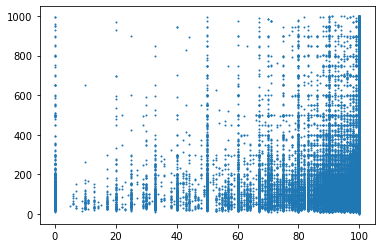

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

Y_array = np.array(Y)
X_array = np.array(Z["Host Response Rate"])

ax.scatter(X_array, Y_array, s = 1, )


Fit a preliminary Linear Regression and Lasso Model to the tabular data to get a benchmark error

Create train and test set from entire data set

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

Z_train, Z_test, Y_train, Y_test = train_test_split(Z, Y, test_size=0.4, random_state=0)
print(Z_train.shape, Z_test.shape, Y_train.shape, Y_test.shape)


(105815, 360) (70544, 360) (105815,) (70544,)


Linear Regression

In [37]:
import statsmodels.api as sm

Z_train_sm = sm.add_constant(Z_train)
Z_test_sm = sm.add_constant(Z_test)
reg1 = sm.OLS(Y_train, Z_train_sm).fit()

print(reg1.summary())
Y_hat_train = reg1.predict(Z_train_sm)
train_error_reg1 = np.sqrt(mean_squared_error(Y_train, Y_hat_train))
print("Train error: " + str(train_error_reg1))

Y_hat = reg1.predict(Z_test_sm)
test_error_reg1 = np.sqrt(mean_squared_error(Y_test, Y_hat))
print("Test error: " + str(test_error_reg1))

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     1033.
Date:                Wed, 20 Sep 2023   Prob (F-statistic):               0.00
Time:                        14:50:10   Log-Likelihood:            -5.8922e+05
No. Observations:              105815   AIC:                         1.179e+06
Df Residuals:                  105478   BIC:                         1.182e+06
Df Model:                         336                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

Normalize numerical features for Lasso Regression

In [38]:
Z_train.iloc[:,:40].head()

,Host Response Rate,Host Listings Count,Accommodates,Bathrooms,Bedrooms,Beds,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Reviews per Month,waterfront,bbq grill,free parking on premises,doorman entry,other pet(s),beachfront,cleaning before checkout,air conditioning,room-darkening shades,high chair,cat(s),hot tub,hangers,window guards,beach essentials,private living room
136939,100.0,4.0,2.0,1.0,0.0,1.0,25.0,1.0,24.0,2.0,30.0,2.0,3.0,18.0,275.0,25.0,98.0,10.0,10.0,10.0,10.0,9.0,10.0,1.50,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
61550,57.0,1.0,2.0,1.0,1.0,1.0,85.0,1.0,0.0,3.0,1125.0,2.0,7.0,7.0,112.0,9.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0.82,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
85829,100.0,3.0,2.0,1.0,1.0,1.0,20.0,2.0,50.0,1.0,1125.0,13.0,43.0,63.0,322.0,10.0,98.0,10.0,10.0,9.0,10.0,10.0,9.0,2.31,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
32976,80.0,1.0,2.0,2.0,1.0,2.0,150.0,2.0,50.0,1.0,1125.0,1.0,12.0,42.0,73.0,1.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0.05,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
18956,57.0,2.0,4.0,1.0,1.0,1.0,10.0,1.0,15.0,1.0,1125.0,30.0,60.0,90.0,365.0,3.0,87.0,9.0,8.0,9.0,10.0,9.0,9.0,1.96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
scaler = StandardScaler().fit(Z_train.iloc[:,:24])
Z_train_lasso = scaler.transform(Z_train.iloc[:,:24])
Z_test_lasso = scaler.transform(Z_test.iloc[:,:24])
Z_train_lasso = pd.DataFrame(Z_train_lasso, columns = Z_train.iloc[:,:24].columns)
Z_test_lasso = pd.DataFrame(Z_test_lasso, columns = Z_test.iloc[:,:24].columns)
Z_train_lasso.shape

(105815, 24)

In [40]:
Z_train.drop(columns = df_numerical.columns).reset_index(drop=True).shape

(105815, 336)

In [41]:
Z_train_lasso = pd.concat([Z_train_lasso, Z_train.drop(columns = df_numerical.columns).reset_index(drop=True)], axis = 1)
Z_train_lasso.shape

(105815, 360)

In [42]:
Z_test_lasso = pd.concat([Z_test_lasso, Z_test.drop(columns = df_numerical.columns).reset_index(drop=True)], axis = 1)
Z_test_lasso.shape

(70544, 360)

Lasso Regression

In [43]:
from sklearn.linear_model import LassoCV

reg_lasso = LassoCV(cv=5, random_state=0, max_iter=10000)
reg_lasso.fit(Z_train_lasso, Y_train)
optimal_alpha = reg_lasso.alpha_
optimal_alpha

0.09954485621268716

In [44]:
from sklearn.linear_model import Lasso

reg2 = Lasso(alpha=optimal_alpha)
reg2.fit(Z_train_lasso, Y_train)
Y_hat_train_lasso = reg2.predict(Z_train_lasso)
Y_hat_lasso = reg2.predict(Z_test_lasso)
train_error_reg2 = np.sqrt(mean_squared_error(Y_train, Y_hat_train_lasso))
print("Train error: " + str(train_error_reg2))
test_error_reg2 = np.sqrt(mean_squared_error(Y_test, Y_hat_lasso))
print("Test error: " + str(test_error_reg2))


Train error: 63.97901767441632
Test error: 63.79822558978584


Check first 5 Thumbnail Urls

In [45]:
airbnb3["Thumbnail Url"].iloc[0:5]

0    https://a0.muscache.com/im/pictures/74942550/4...
1    https://a0.muscache.com/im/pictures/eb9e20e1-9...
2    https://a0.muscache.com/im/pictures/10232036/f...
3    https://a0.muscache.com/im/pictures/4aad80ac-8...
4    https://a0.muscache.com/im/pictures/10553335/6...
Name: Thumbnail Url, dtype: object

Display a random image

(144, 216, 3)


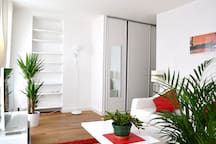

In [46]:
url = airbnb3["Thumbnail Url"].iloc[137589]
response = requests.get(url)
if response.status_code == 200:    
    img = Image.open(BytesIO(response.content))
    img_array = np.array(img)
    print(img_array.shape)
    display(img)

Check shapes of the first one hundred images

In [47]:
img_shapes = []
for url in airbnb3.loc[:100,"Thumbnail Url"]:
    response = requests.get(url)
    if response.status_code == 200:    
        img = Image.open(BytesIO(response.content))
        img_array = np.array(img)
        img_shapes.append(img_array.shape)

img_shapes

[(144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3)]

In [48]:
len(img_shapes)

59

In [4]:
import os
from urllib.parse import urlparse

output_folder = "images2"
os.makedirs(output_folder, exist_ok=True)

urls = airbnb5.loc[:100, "Thumbnail Url"]
indices = []
for index, url in enumerate(urls):
    response = requests.get(airbnb5["Thumbnail Url"].iloc[i])
    if response.status_code == 200:
        indices.append(index)
        img = Image.open(BytesIO(response.content))
        filename = os.path.join(output_folder,f"image_{index}.jpg")
        if img.mode == "RGB":
            img.save(filename)
            print(f"saved image {index}")
        else:
            img.convert("RGB")
            img.save(filename)
            print(f"saved image {index}")




NameError: name 'airbnb5' is not defined

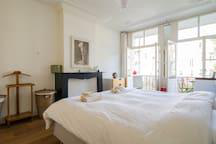

In [125]:
images = []
path = "images/"
for f in os.listdir(path):
    images.append(Image.open(os.path.join(path,f)))

images[0]

In [126]:
len(indices)

669

In [127]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [128]:
inputs = processor(text="room", images=images, return_tensors="pt")

In [129]:
outputs = model(**inputs)

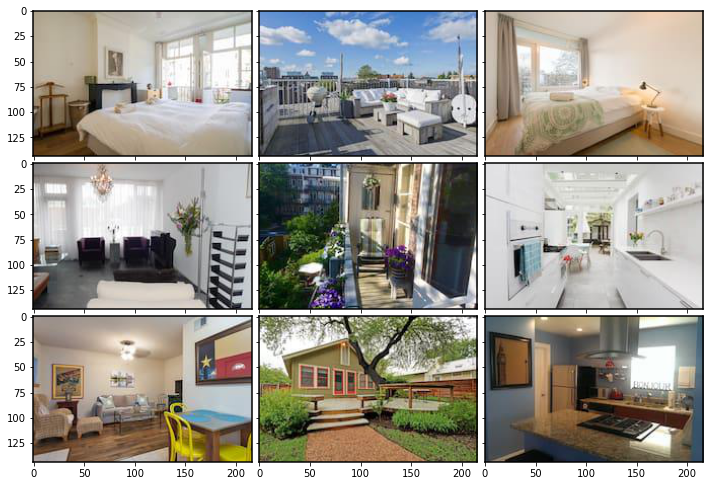

In [130]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline

im = []
for i in range(len(images[:9])):
    im.append(images[i])

fig = plt.figure(1,(12.,12.))
grid = ImageGrid(fig, 111, nrows_ncols= (3,3), axes_pad=0.1,)

for i in range(9):
    grid[i].imshow(im[i])

In [131]:
import numpy as np
logits_per_image = outputs.logits_per_image
logits_per_image_np = logits_per_image.detach().numpy()
logits_per_image_np = logits_per_image_np.reshape((logits_per_image_np.shape[0],))
logits_per_image_np.shape

(669,)

Mean: 24.504555
Median: 24.90773
Std: 2.3248563
Lower Whisker: 19.330774


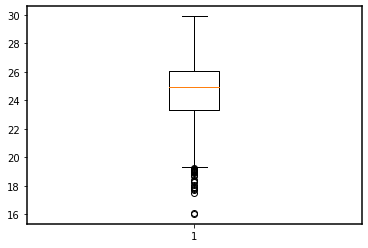

In [147]:
plt.boxplot(logits_per_image_np)
sim_mean = np.mean(logits_per_image_np)
print("Mean: " + str(sim_mean))
print("Median: " + str(np.median(logits_per_image_np)))
print("Std: " + str(np.std(logits_per_image_np)))
lower_quartile = np.percentile(logits_per_image_np, 25)
upper_quartile = np.percentile(logits_per_image_np, 75)
iqr = upper_quartile - lower_quartile
lower_whisker = logits_per_image_np[logits_per_image_np>lower_quartile-1.5*iqr].min()
print("Lower Whisker: " + str(lower_whisker))

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

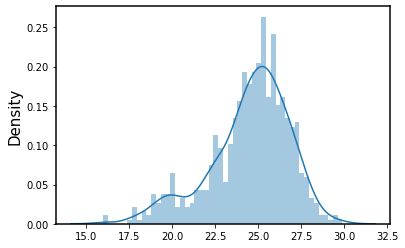

In [145]:
import seaborn as sns

sns.displot(logits_per_image_np, kde=True, bins=50)

In [155]:
indices_outside_images = []
outliers = logits_per_image_np < lower_whisker
for i in range(len(logits_per_image_np)):
    if outliers[i]:
        indices_outside_images.append(i)


array([18.9858  , 17.724442, 18.25215 , 18.97798 , 17.47991 , 19.157436,
       18.702496, 17.937485, 18.028957, 17.821608, 18.38396 , 18.881168,
       18.73981 , 19.028091, 19.127085, 19.274744, 16.079893, 17.733797,
       19.071793, 16.016644, 19.15836 , 19.020649, 18.365328, 19.062351],
      dtype=float32)

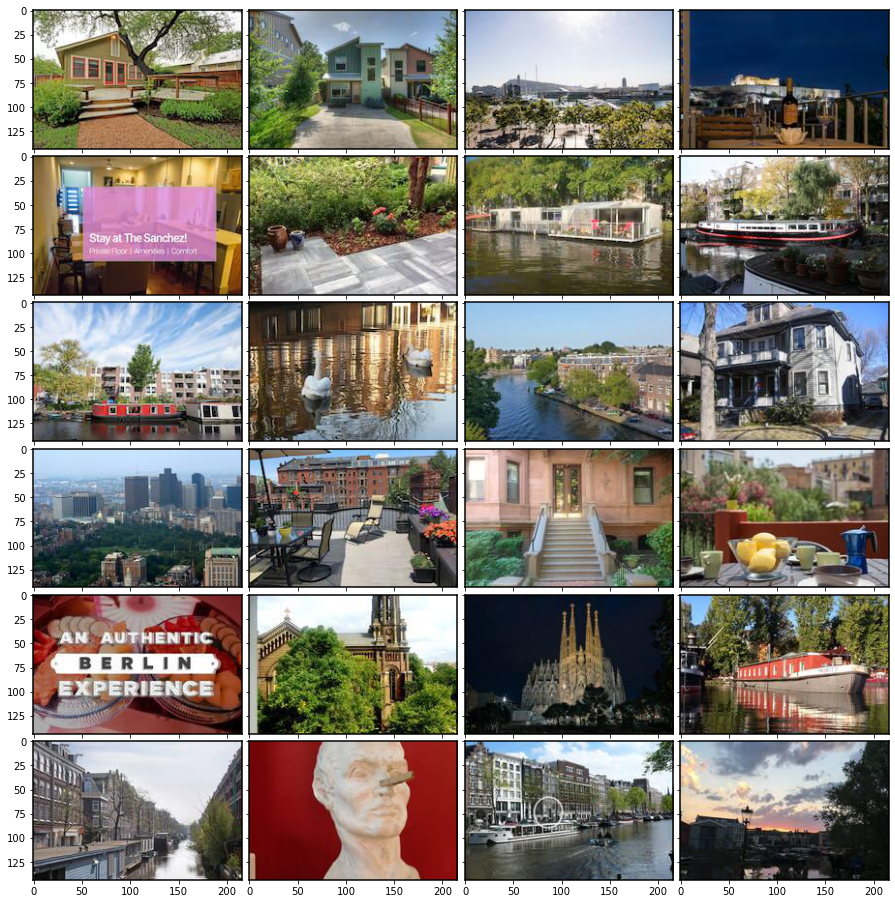

In [156]:

outside_images = []
for i in indices_outside_images:
    outside_images.append(images[i])

fig = plt.figure(1,(20.,16.))
grid = ImageGrid(fig, 111, nrows_ncols= (6,4), axes_pad=0.1,)

for i in range(len(indices_outside_images)):
    grid[i].imshow(outside_images[i])